In [ ]:
!pip install -U colorama
!pip install PyYAML
!pip install rsa
!pip install -U bayesian-optimization
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

data = pd.read_csv('german_credit_data (1).csv')

print(data.size)

features = data.iloc[:,:-1]
labels = data.iloc[:,-1]

one_hot_categorical_features = [9]
ordinal_categorical_features = [1,3,7]

one_hot_encoder = OneHotEncoder(sparse_output=False)
ordinal_encoder = OrdinalEncoder()

one_hot_encoded_features = pd.DataFrame()
ordinal_encoded_features = pd.DataFrame()

for feature in one_hot_categorical_features:
    encoded = one_hot_encoder.fit_transform(features[[features.columns[feature]]])
    encoded_df = pd.DataFrame(encoded, columns=one_hot_encoder.get_feature_names_out([features.columns[feature]]))
    one_hot_encoded_features = pd.concat([one_hot_encoded_features, encoded_df], axis=1)

for feature in ordinal_categorical_features:
    encoded = ordinal_encoder.fit_transform(features[[features.columns[feature]]])
    encoded_df = pd.DataFrame(encoded, columns=[features.columns[feature]])
    ordinal_encoded_features = pd.concat([ordinal_encoded_features, encoded_df], axis=1)

print("One hot Encoded Features:")
print(one_hot_encoded_features.head())
print()

print("Ordinal Encoded Features:")
print(ordinal_encoded_features.head())
print()

encoded_features = pd.concat([one_hot_encoded_features, ordinal_encoded_features], axis=1)

non_categorical_features = [column for column in features.columns if column not in one_hot_categorical_features + ordinal_categorical_features]
encoded_features = pd.concat([encoded_features, features[non_categorical_features]], axis=1)

print("Encoded Features:")
print(encoded_features.head())
print()

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

num_features = encoded_features.select_dtypes(include=['float64', 'int64'])
cat_features = encoded_features.select_dtypes(include=['object'])

print("Categorical Features:")
print(cat_features.head())

imputed_num = pd.DataFrame(imputer_num.fit_transform(num_features), columns=num_features.columns)
imputed_cat = pd.DataFrame(imputer_cat.fit_transform(cat_features), columns=cat_features.columns)

df_encoded = imputed_cat.copy()
df_encoded = pd.get_dummies(df_encoded)

print("Encoded Category:")
print(df_encoded.head())

label_encoder = LabelEncoder()
encodedLabels = label_encoder.fit_transform(labels)

imputedFeatures = pd.concat([imputed_num, df_encoded], axis=1)
imputedFeatures, encodedLabels = shuffle(imputedFeatures, encodedLabels)

print("Impuded Features:")
print(imputedFeatures.head())

def evaluate_decision_tree(max_depth, min_samples_leaf):
    model = DecisionTreeClassifier(max_depth=int(max_depth), min_samples_leaf=int(min_samples_leaf), criterion='gini')
    return cross_val_score(model, imputedFeatures, encodedLabels, cv=10).mean()

bayesian_optimization = BayesianOptimization(evaluate_decision_tree, {'max_depth': (1, 10), 'min_samples_leaf': (1, 5)})
bayesian_optimization.maximize(n_iter=50, init_points=2)

best_params = bayesian_optimization.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

print("Best parameters from Bayesian Optimization:")
print(best_params)

tree = DecisionTreeClassifier(**best_params)
tree.fit(imputedFeatures, encodedLabels)

trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(imputedFeatures, encodedLabels, test_size=0.25, random_state=42)

predictedLabels = tree.predict(testFeatures)

accuracy = accuracy_score(testLabels, predictedLabels)
print('Accuracy:', accuracy)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
11000
One hot Encoded Features:
   Purpose_business  Purpose_car  Purpose_domestic appliances  \
0               0.0          0.0                          0.0   
1               0.0          0.0                          0.0   
2               0.0          0.0                          0.0   
3               0.0          0.0                          0.0   
4               0.0          1.0                          0.0   

   Purpose_education  Purpose_furniture/equipment  Purpose_radio/TV  \
0                0.0                          0.0               1.0   
1                0.0                   

Logistic Regression Accuracy: 0.7
        Parameters  Mean Test Score
0       {'C': 0.1}            0.714
1       {'C': 0.5}            0.716
2       {'C': 1.0}            0.721
3       {'C': 1.5}            0.718
4       {'C': 2.0}            0.717
5       {'C': 2.5}            0.720
6       {'C': 5.0}            0.719
7      {'C': 10.0}            0.719
8      {'C': 20.0}            0.721
9      {'C': 50.0}            0.717
10    {'C': 100.0}            0.718
11    {'C': 250.0}            0.722
12    {'C': 500.0}            0.726
13   {'C': 1000.0}            0.718
14  {'C': 10000.0}            0.718
15  {'C': 50000.0}            0.720


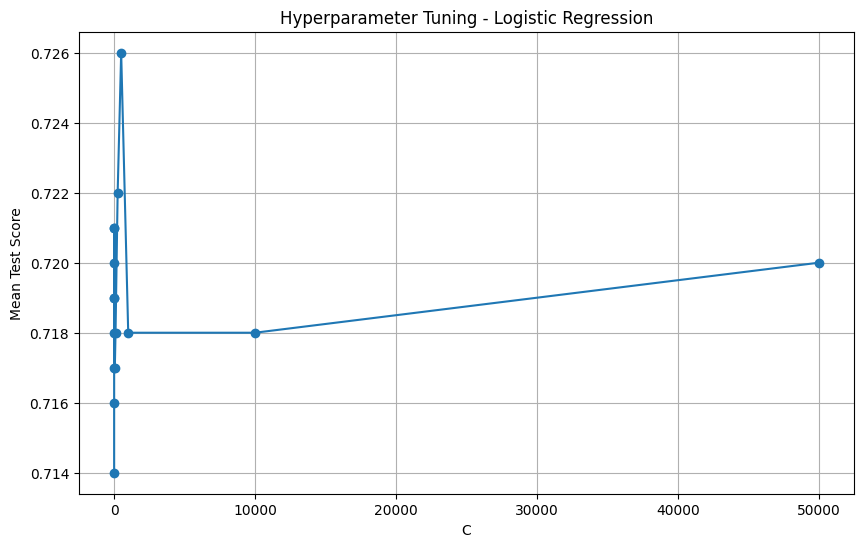

In [ ]:
param_grid = {'C': [0.1,0.5,1.0,1.5,2.0,2.5,5.0,10.0,20.0,50.0,100.0,250.0,500.0,1000.0,10000.0,50000.0]}
lrm = LogisticRegression(max_iter=10000)
grid_search = GridSearchCV(lrm, param_grid, cv=5)
grid_search.fit(imputedFeatures, encodedLabels)
best_lrm = grid_search.best_estimator_
best_lrm.fit(imputedFeatures, encodedLabels)
predictedLabels_lrm = best_lrm.predict(testFeatures)
accuracy_lrm = accuracy_score(testLabels, predictedLabels_lrm)
print('Logistic Regression Accuracy:', accuracy_lrm)

grid_search.fit(imputedFeatures, encodedLabels)
results = grid_search.cv_results_
param_results = list(zip(results['params'], results['mean_test_score']))
df = pd.DataFrame(param_results, columns=['Parameters', 'Mean Test Score'])
print(df)
plt.figure(figsize=(10, 6))
plt.plot(results['param_C'], results['mean_test_score'], marker='o')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title('Hyperparameter Tuning - Logistic Regression')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_knn(n_neighbors):
    model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
    return cross_val_score(model, imputedFeatures, encodedLabels, cv=10).mean()

bayesian_optimization_knn = BayesianOptimization(evaluate_knn,{'n_neighbors': (1, 10)})
bayesian_optimization_knn.maximize(n_iter=20, init_points=5)

best_params_knn = bayesian_optimization_knn.max['params']
best_params_knn['n_neighbors'] = int(best_params_knn['n_neighbors'])

print("Best parameters from Bayesian Optimization for KNN:")
print(best_params_knn)

knn = KNeighborsClassifier(**best_params_knn)
knn.fit(imputedFeatures, encodedLabels)

predictedLabels_knn = knn.predict(testFeatures)

accuracy_knn = accuracy_score(testLabels, predictedLabels_knn)
print('KNN Accuracy:', accuracy_knn)

|   iter    |  target   | n_neig... |
-------------------------------------
| 1         | 0.666     | 9.861     |
| 2         | 0.552     | 4.247     |
| 3         | 0.576     | 1.133     |
| 4         | 0.623     | 6.241     |
| 5         | 0.625     | 3.299     |
| 6         | 0.666     | 9.871     |
| 7         | 0.643     | 8.553     |
| 8         | 0.672     | 7.446     |
| 9         | 0.484     | 2.441     |
| 10        | 0.672     | 7.943     |
| 11        | 0.623     | 6.903     |
| 12        | 0.651     | 5.436     |
| 13        | 0.666     | 9.196     |
| 14        | 0.672     | 7.693     |
| 15        | 0.651     | 5.772     |
| 16        | 0.666     | 9.465     |
| 17        | 0.643     | 8.157     |
| 18        | 0.643     | 8.9       |
| 19        | 0.666     | 9.871     |
| 20        | 0.552     | 4.999     |
| 21        | 0.625     | 3.662     |
| 22        | 0.672     | 7.253     |
| 23        | 0.672     | 7.827     |
| 24        | 0.672     | 7.341     |
| 25        